# Last homework: designing a microscope using machine learning

For the final homework assignment, we will design a microscope using machine learning! In order to do this, we will combine elements of HW3 (CNNs) and HW4 (microscope simulator) into a single end-to-end architecture. In particular, we will convert the MNIST digits into phase/amplitude objects and process them through a microscope simulator as we did in HW4, add noise, and then feed the output into a CNN to classify the digit. In addition to optimizing the CNN parameters, we will also be simultaneously optimizing the input illumination incident on the sample as well as the aperture plane.

Below, we will walk you through the steps of implementing this joint architecture, leaving some portions blank for you to implement. We will first instruct you to use specific values that we have tested and are known to give reasonable results. Later on, you will revisit the code and explore different hyperparameter settings.

## 1. import stuff and load MNIST
As always, we split the dataset into training and testing. This code was copied from the jupyter notebook from TA session 5 and slightly modified.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# load MNIST dataset:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# verify that the shapes are correct:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# cast as a float32:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## 2. convert the MNIST images into microscope samples
Convert the MNIST images into phase-only objects. To do this, normalize the MNIST digits to be between 0 and 1, and make the object 1 wavelength thick (we may come back later to adjust the sample thickness).

In [2]:
wavelength = .5
optical_thickness = 1 * wavelength

def convert_MNIST(X):
    X = X/X.max()
    #Xout = X * np.exp(1j*X*np.random.uniform(0,1))
    Xout = X * np.exp(1j * X*np.random.uniform(0,1))
    return Xout

X_train_norm = convert_MNIST(X_train)
X_test_norm = convert_MNIST(X_test)
X_train_norm=X_train_norm.reshape([X_train_norm.shape[0],28,28,1])
X_test_norm=X_test_norm.reshape([X_test_norm.shape[0],28,28,1])
print(X_train_norm.shape)
print(X_test_norm.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## 3. create input pipeline for generating training/testing batches
For your convenience, this was also copied from TA session 5 (and slightly modified). You don't need to do anything here but run this block:

In [3]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.complex64, [None, 28, 28, 1], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

Instructions for updating:
Colocations handled automatically by placer.


## 4. create complex-valued trainable illumination
The input field will be a 28x28 complex-valued field that interacts with the sample. In practice, this input field might be obtained by using a spatial light modulator (SLM), an optical element that can be programmed to display an arbitrary phase and/or amplitude pattern pixel by pixel. We will use a phase-only SLM, so that the variable to optimize is a 28x28 array of phases (from 0 to 2pi).

In [4]:
# use this flag to allow/disallow training of the input illumination; tf.Variable has an argument called "trainable":
train_illumination = True

# create the variable corresponding to the input illumination phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
# C0_imag=tf.Variable(tf.random_uniform(shape=[28,28],minval=0,maxval=2*np.pi,dtype=tf.dtypes.float32))
C0_im=tf.Variable(tf.ones(shape=(28,28,1))*tf.random_uniform(shape=[1,1]),dtype=tf.dtypes.float32,trainable=train_illumination)
# C0_im=tf.Variable(tf.ones(shape=(28,28,1)),dtype=tf.dtypes.float32,trainable=train_illumination)
C0_re=tf.zeros(shape=(28,28,1))
#C0_im = tf.math.sin(C0_angle)
#C0_re = tf.math.cos(C0_angle)
C_complex=tf.complex(C0_re,C0_im)

input_illumination=C_complex
print(input_illumination.shape)

(28, 28, 1)


## 5. generate the emerging field from the sample
Given a stack of input images, X_batch (generated above), create a tensorflow array representing the emerging field from the sample. This is the same as what you did in HW4, except in HW4 you had a tilted plane wave.

In [5]:
# be sure to match the shapes/dimensions to enable broadcasting:
#input_illumination2=np.repeat(input_illumination,batch_size,axis=0)

emerging_field = input_illumination*X_batch

        
print(emerging_field.shape)

(?, 28, 28, 1)


## 6. propagate the emerging field to the aperture plane
As in HW4, propagate the field emerging from the sample to the aperture plane (also known as the Fourier plane). Remember to use tensorflow operations!

In [0]:
aperture_plane = tf.fft2d(emerging_field)

def tf_fftshift2(A):
      # 2D fftshift
      # apply fftshift to the last two dims
      s = tf.shape(A)
      s1 = s[-2] + 1
      s2 = s[-1] + 1
      A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
      A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
      return A
    
aperture_plane = tf_fftshift2(aperture_plane)

## 7. create complex-valued trainable aperture function
In HW4, we modeled a circular aperture in the aperture plane of our microscope. Please do the same here. For now, in whatever coordinate system you have established, please try to ensure that the radius extends across 8 pixels of the 28 pixels that will define the k-space matrix for this MNIST dataset along one dimension. We may come back later to adjust this radius.

In addition, for extra flexibility, let's add an SLM in the aperture plane. Assume the SLM is a phase-only SLM (only values from 0 to 2pi are allowed).

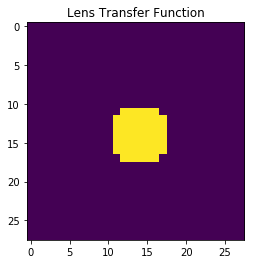

In [7]:
# use this flag to allow/disallow training of the aperture plane; pass this into the tf.Variable definition:
train_aperture = True

# the aperture function consists of two parts: 1) the circular aperture as in HW4, and 2) a trainable 28x28 phase array
# create a circular aperture as you did in HW4:
lensNA=8/28
def create_circular_aperture(lensNA, size):
    lens = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            dist = np.sqrt((i-size/2)**2+(j-size/2)**2)
            if dist < lensNA/2*size:
                lens[i,j] = 1
    return lens

# Aperture=create_circular_aperture(28, 28, None, radius=lensNA*(28)/2)
circ_aper=create_circular_aperture(lensNA,28)
#circ_aper=Aperture*1
plt.figure()
plt.imshow(circ_aper)   
plt.title('Lens Transfer Function')
circ_aper = circ_aper.reshape([28,28,1])
# create the variable corresponding to the aperture phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
aperture_im = tf.Variable(tf.ones((28,28,1))*tf.random_uniform(shape=[1,1]),dtype=tf.dtypes.float32,trainable=train_aperture)
#aperture_im = tf.Variable(tf.ones((28,28,1)),dtype=tf.dtypes.float32,trainable=train_aperture)

#circ_aper = tf.convert_to_tensor(circ_aper, np.float32)
circ_aper = circ_aper.astype(np.float32)
# write the full aperture function, combining the above two components:
aperture = tf.complex(circ_aper,aperture_im)

# filter the field that you propagated:

aperture_plane_filtered = aperture*aperture_plane


## 8. propagate to the image plane
Next, we propagate the field to the image plane and take the magnitude squared (since we can only measure intensity). Add some Gaussian noise, since real measurements are noisy. Use tf.random_normal and for now use a stddev of .05. 

In [0]:
# propagate the field from the aperture plane to the image plane and convert it to intensity:

def tf_ifftshift2(A):
      # 2D ifftshift
      # apply ifftshift to the last two dims
      s = tf.shape(A)
      s1 = s[-2]
      s2 = s[-1]
      A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
      A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
      return A
image=tf_ifftshift2(aperture_plane_filtered)
image = tf.ifft2d(image)

image_intensity=(abs(image))**2
noise= tf.random_normal(shape=(28,28,1),stddev=0.05)

# add noise:
image_detected =image_intensity + noise

## 9. process the simulated image through a CNN
Use your favorite CNN architecture that classifies MNIST or come up with a new one. You may copy a network architecture from a previous TA or class session.

In [9]:
imgfeed = tf.reshape(image_detected, [-1, 28, 28, 1])
net_input_layer = imgfeed  # add a channels dimension

# add some convolutional layers:
net = tf.layers.conv2d(net_input_layer, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
#net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)
net = tf.layers.conv2d(net, filters=128, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=10)

logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=10), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.2).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


## 10. train!

In [0]:
# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train_norm, y_train_or_test: y_train})

Let's first look at a few simulated noisy microscope images.

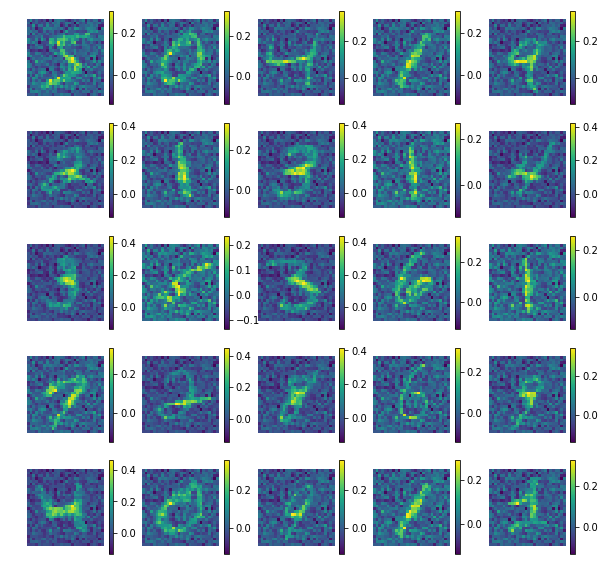

In [11]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i].reshape([28,28]))
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(image_detected.eval())


Write your train loop here. Feel free to monitor loss and/or aperture/illumination phases during training. When we tested this, the optimizer had a slow start, and we had to run for several 1000 batches. Pick a value for the number of iterations and keep it fixed.

In [12]:
# train loop:
epochs=5
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    for i in range(1000):
        _, loss_i = sess.run([train_op, loss])
        
        if i%100 == 0:
            print(loss_i)

Training epoch: 1
2.2986698
1.4160488
0.40978342
0.14616102
0.35866153
0.3601073
0.3992107
0.04925111
0.08043511
0.120797366
Training epoch: 2
0.11137974
0.3091449
0.04439523
0.03610177
0.23120472
0.12745231
0.3758453
0.037019037
0.04373289
0.11053714
Training epoch: 3
0.08851368
0.116181955
0.018309988
0.10029429
0.0029312212
0.04285873
0.0052271388
0.11182838
0.0021877955
0.004987359
Training epoch: 4
0.08050454
0.03198284
0.07863842
0.04948863
0.003791886
0.0053729
0.031975456
0.0015166424
0.016217122
0.004239716
Training epoch: 5
0.015186803
0.005711253
0.08850298
0.0071911523
0.013975051
0.050216533
0.06930597
0.006798345
0.00037595356
0.0045761843


Let's first look at a few simulated noisy microscope images AFTER training. Do the images look more recognizable?

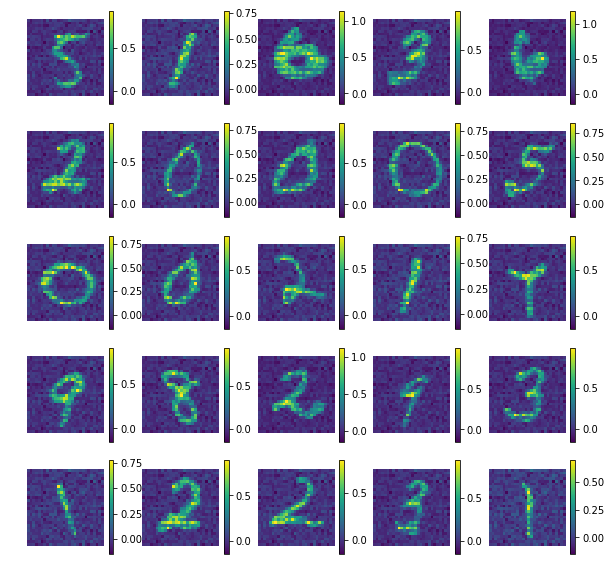

In [13]:
# plot examples 
plot_examples(image_detected.eval())

Pass through the test set.

In [14]:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test_norm, y_train_or_test: y_test})
correct = 0
total = 0
for i in range(100):
    prediction, truth = sess.run([logits, y_batch])
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print(acc)

illu_phase=sess.run(input_illumination[0][0])
print('optimized illumination phase',illu_phase)
apr_phase=sess.run(aperture[15][15])
print('optimized aperture phase',apr_phase)

sess.close()

0.9790625
optimized illumination phase [0.+0.4116789j]
optimized aperture phase [1.+0.8608313j]


### Ok, now you've run a machine learning model with a physical layer! You did it! Please respond to the following questions. Note that this is a pretty open-ended analysis, and everyone may achieve different results depending on the selected parameters -- as long as you get question 1 to work, it's okay if the other questions give uninteresting results!

### 1. First, using the default hyperparameters based on the instructions and code we provided, please run the training under the following conditions:
###     1. Allowing optimization of aperture phase and illumination phase.
###     2. Allowing optimization of neither aperture phase nor illumination phase (this is a control experiment, because only the CNN is trained).
###     3. Allowing optimization of only the aperture phase.
###    4. Allowing optimization of only the illumination phase.
    
###    For these 4 conditions, report the final test classification accuracies as well as the optimized aperture phase and/or illumination phase. Provide a brief analysis of the results (hint: if you don't see a difference between at least two of the above conditions, something probably went wrong!).
   
   
Answers: 
1. Allow optimization of both aperture and illumination phase:

  Accuracy: 98%
  
  optimized illumination phase: 0.721
  
  optimized aperture phase: 0.512

2. Allowing optimization of neither aperture phase nor illumination phase:

  accuracy: 82.1%
  
  Illumination phase: 0.704
  
  aperture phase: 0.259
  
3. Allowing optimization of only the aperture phase.

  Accuracy: 97.8%
  
  illumination phase: 0.824
  
  optimized aperture phase: 0.503
  
4. Allowing optimization of only the illumination phase:

  Accuracy is: 96.8%

  optimized illumination phase: 0.242

  aperture phase: 0.694
  
 Comment: without allowing the optimization of either aperture phase or illumination phase, the accuracy decreases. When enable both illumination and aperture phase optimizations, the accuracy is slightly higher than optimize only one. In addition, the accuracy also strongly depends on the distortion of initial images. 

In [0]:
def plot_examples1(batch):
    plt.figure(figsize=(5, 5))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(batch[i].reshape([28,28]))
        plt.colorbar()
        plt.axis('off')
    plt.show()

In [2]:
def illumination_aperture_train2(illumination_allow, aperture_allow, phase_constant, learning_rate,NA):
  # this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
  X_train_or_test = tf.placeholder(tf.complex64, [None, 28, 28, 1], name='input_image')
  y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
  batch_size = 32

  # create a tf dataset, from which we can generate batches
  dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
  dataset = dataset.batch(batch_size).repeat(None)
  batch_generator = dataset.make_initializable_iterator()
  X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated
  
  # illmination field
  if phase_constant==True:    
    C0_im=tf.Variable(tf.ones(shape=(28,28,1))*tf.random_uniform(shape=[1,1]),dtype=tf.dtypes.float32,trainable=illumination_allow)
  elif phase_constant==False:
    C0_im=tf.Variable(tf.random_uniform(shape=[28,28,1]),dtype=tf.dtypes.float32,trainable=illumination_allow)
  
  
  C0_re=tf.zeros(shape=(28,28,1))
  input_illumination=tf.complex(C0_re,C0_im)
  emerging_field = input_illumination*X_batch 
  aperture_plane = tf.fft2d(emerging_field) 
  aperture_plane = tf_fftshift2(aperture_plane)
  

  # aperture
  circ_aper=create_circular_aperture(NA,28)
  plt.figure()
  plt.imshow(circ_aper)   
  plt.title('Lens Transfer Function')
  circ_aper = circ_aper.reshape([28,28,1])
  circ_aper = circ_aper.astype(np.float32)
  if phase_constant==True:   
      aperture_im = tf.Variable(tf.ones((28,28,1))*tf.random_uniform(shape=[1,1]),dtype=tf.dtypes.float32,trainable=aperture_allow)
  elif phase_constant==False:
      aperture_im = tf.Variable(tf.random_uniform(shape=[28,28,1]),dtype=tf.dtypes.float32,trainable=aperture_allow)
    
  aperture = tf.complex(circ_aper,aperture_im)
  aperture_plane_filtered = aperture*aperture_plane
  
  # detected
  image=tf_ifftshift2(aperture_plane_filtered)
  image = tf.ifft2d(image)
  image_intensity=(abs(image))**2
  noise= tf.random_normal(shape=(28,28,1),mean=0.025,stddev=0.05)
  image_detected =image_intensity + noise
  
  imgfeed = tf.reshape(image_detected, [-1, 28, 28, 1])
  net_input_layer = imgfeed  # add a channels dimension
  

  
  # Make model
  net = tf.layers.conv2d(net_input_layer, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
  net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)
  net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
  net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)
  net = tf.layers.conv2d(net, filters=128, kernel_size=3, padding='SAME', activation=tf.nn.relu)
  net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)
  net = tf.layers.flatten(net)
  net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
  net = tf.layers.flatten(net)
  net = tf.layers.dense(net, units=10)
  logits = net
  loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=10), logits=logits)

  train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
  sess = tf.InteractiveSession()
  sess.run(tf.global_variables_initializer())
  sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train_norm, y_train_or_test: y_train})
  
  # before training
  plot_examples1(image_detected.eval())
  
  # train loop:

  for i in range(5000):
      _, loss_i = sess.run([train_op, loss])
      if i%250 == 0:
         print(loss_i)
  
  plot_examples1(image_detected.eval())       
  # accuracy   
  sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test_norm, y_train_or_test: y_test})
  correct = 0
  total = 0
  for i in range(100):
      prediction, truth = sess.run([logits, y_batch])
      correct += np.sum(prediction.argmax(1)==truth)
      total += len(truth)
  acc = correct/total
  print('Accuracy is:',acc)
  
  illu_phase=sess.run(input_illumination[0][0])
  print('optimized illumination phase',illu_phase)
  apr_phase=sess.run(aperture[15][15])
  print('optimized aperture phase',apr_phase)
  
  sess.close()
  return acc

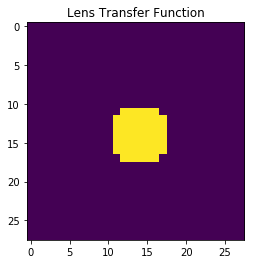

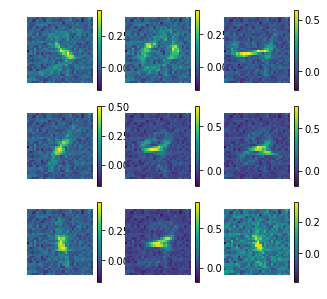

2.2987022
0.29723537
0.4917124
0.33092475
0.19336662
0.017023087
0.22986318
0.05536102
0.056771725
0.007920908
0.04199925
0.0026442371
0.031529453
0.034206204
0.0059037562
0.031223208
0.009791087
0.020323636
0.03276129
0.020441614


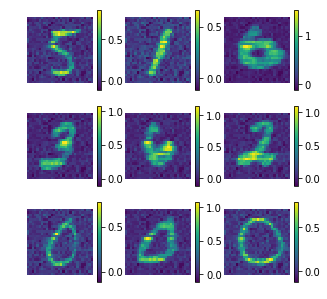

Accuracy is: 0.9796875
optimized illumination phase [0.+0.72068787j]
optimized aperture phase [1.+0.5116117j]


0.9796875

In [83]:
# 1-A enable both illumination and aperture training
illumination_allow=True
aperture_allow=True
phase_constant=True
learning_rate=0.2
NA=8/28
illumination_aperture_train2(illumination_allow, aperture_allow, phase_constant, learning_rate,NA)

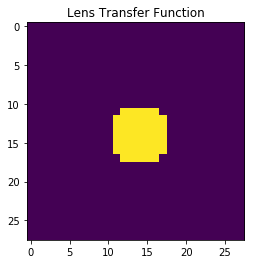

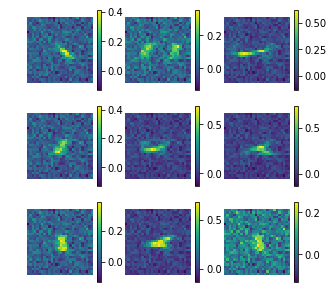

2.3005557
0.7356694
1.0156797
0.70784736
0.5271376
0.5390136
1.0082799
0.30461994
0.36258984
0.40030214
0.29735345
0.42600304
0.36872712
0.19785044
0.1958479
0.2047098
0.22800185
0.5594847
0.38537103
0.3135249


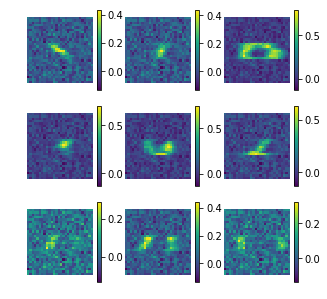

Accuracy is: 0.8209375
optimized illumination phase [0.+0.70430124j]
optimized aperture phase [1.+0.25911582j]


0.8209375

In [86]:
# 1-B disable both illumination and aperture training
illumination_allow=False
aperture_allow=False
phase_constant=True
learning_rate=0.2
NA=8/28
illumination_aperture_train2(illumination_allow, aperture_allow, phase_constant, learning_rate,NA)

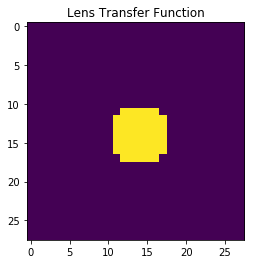

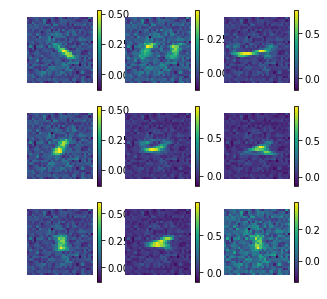

2.301071
0.58630705
0.93559146
0.34010315
0.28199613
0.17661083
0.24946699
0.09801845
0.061284773
0.030108588
0.17566216
0.0041251928
0.04189257
0.0111865755
0.027809532
0.012710204
0.032217033
0.064903975
0.04821471
0.009624177


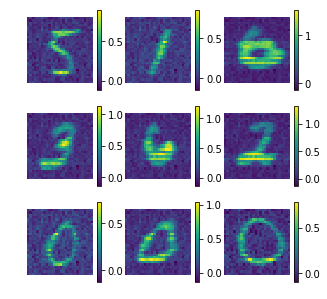

Accuracy is: 0.9775
optimized illumination phase [0.+0.8239969j]
optimized aperture phase [1.+0.5027354j]


0.9775

In [87]:
# 1-C disable illumination training, but enable aperture training
illumination_allow=False
aperture_allow=True
phase_constant=True
learning_rate=0.2
NA=8/28
illumination_aperture_train2(illumination_allow, aperture_allow, phase_constant, learning_rate,NA)

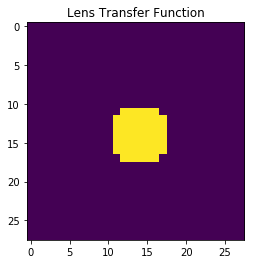

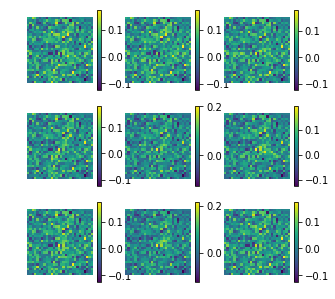

2.3027816
2.2973409
1.9969605
0.94445693
0.56683314
0.2528878
0.20672475
0.07079645
0.21063367
0.051694825
0.14066075
0.008607691
0.11226949
0.066373594
0.041646544
0.048467357
0.018669121
0.061876442
0.114708215
0.015810104


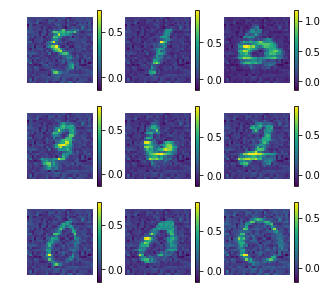

Accuracy is: 0.9684375
optimized illumination phase [0.+0.24244916j]
optimized aperture phase [1.+0.69373834j]


0.9684375

In [89]:
# 1-D enable illumination training, but disable aperture training
illumination_allow=True
aperture_allow=False
phase_constant=True
learning_rate=0.2
NA=8/28
illumination_aperture_train2(illumination_allow, aperture_allow, phase_constant, learning_rate,NA)

### 2. If you got question 1 to work, good work! Next, let's try changing some of the hyperparameters above. For each of the following questions, rerun the analysis from question 1 (under conditions of 1A and 1B). Ideally, we want to find situations where the CNN with the physical layer (the microscope simulating layers) outperforms the CNN-only network. Comment on the gap in performance between the physically-optimized and non-physically-optimized cases. Also comment on the optimized aperture and/or illumination phase.
###    * For question 1, you initialized with a constant phase. Next, try to initialize the optimization with random-valued aperture phase and illumination phase.
###    * Try changing the diameter of the aperture to two other values. For example, half and double the original diameter used above.

Answer: without using physical layers, no improvement on the detected images can be seen. When using random-valued aperture and illumination phases, the detected images can also be optimized, and the accuracy is comparable with constant phase condition. 

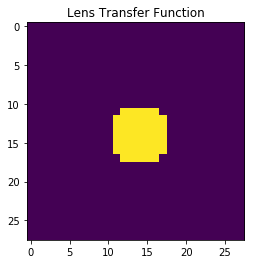

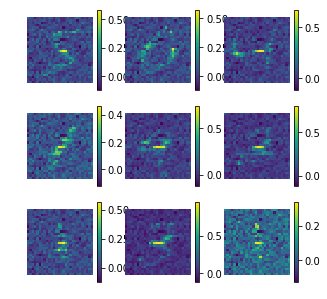

2.3012395
0.48622692
0.55108976
0.37710077
0.17615627
0.058485743
0.12424328
0.04915747
0.06595288
0.008466432
0.04912211
0.0020383215
0.022810772
0.03510402
0.008933071
0.01324193
0.016079148
0.10969432
0.091418855
0.013540066


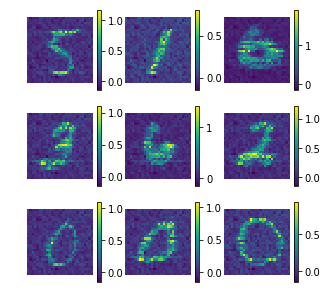

Accuracy is: 0.9775
optimized illumination phase [0.+0.27813447j]
optimized aperture phase [1.+0.73257744j]


0.9775

In [90]:
# 2-A. Random-valued illumination and aperture phase
# illumination and aperture enable

illumination_allow=True
aperture_allow=True
phase_constant=False
learning_rate=0.2
NA=8/28
illumination_aperture_train2(illumination_allow, aperture_allow, phase_constant, learning_rate,NA)

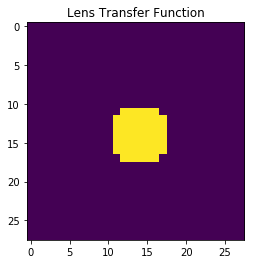

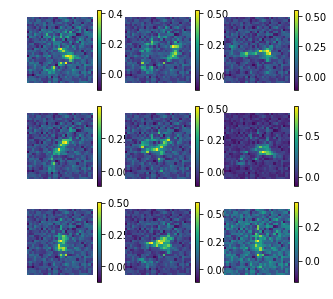

2.3046021
0.4977872
1.1606909
0.42495254
0.24631003
0.23343858
0.3035266
0.19872466
0.4701196
0.19973403
0.24839729
0.05569516
0.11034762
0.10752341
0.1566832
0.08822657
0.07430566
0.1979734
0.2503724
0.16115527


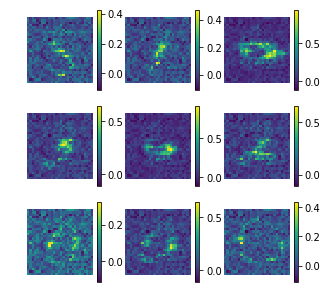

Accuracy is: 0.9253125
optimized illumination phase [0.+0.76692533j]
optimized aperture phase [1.+0.03740978j]


0.9253125

In [91]:
# 2-A. Random-valued illumination and aperture phase
# illumination and aperture disable

illumination_allow=False
aperture_allow=False
phase_constant=False
learning_rate=0.2
NA=8/28
illumination_aperture_train2(illumination_allow, aperture_allow, phase_constant, learning_rate,NA)

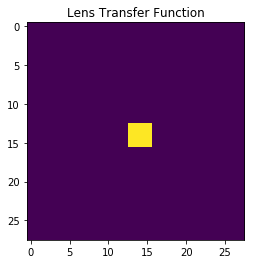

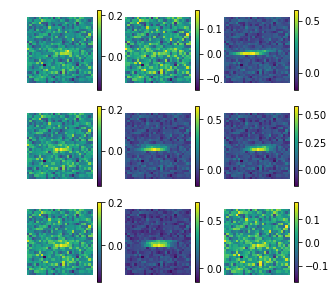

2.305994
1.6797515
1.633564
0.84205675
0.38861436
0.12515076
0.27497947
0.028792817
0.044181526
0.013292909
0.22574836
0.014861576
0.096510105
0.028153898
0.023853274
0.041800465
0.0045493166
0.19110127
0.01885035
0.02395821


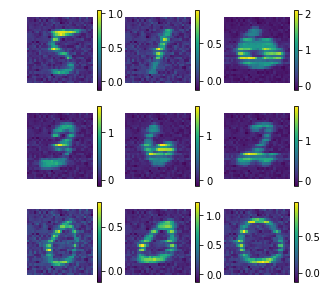

Accuracy is: 0.97625
optimized illumination phase [0.+0.81035984j]
optimized aperture phase [1.+0.71040785j]


0.97625

In [101]:
# half the aperture diameter
illumination_allow=True
aperture_allow=True
phase_constant=True
learning_rate=0.2
NA=8/28/2
illumination_aperture_train2(illumination_allow, aperture_allow, phase_constant, learning_rate,NA)

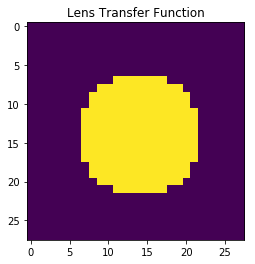

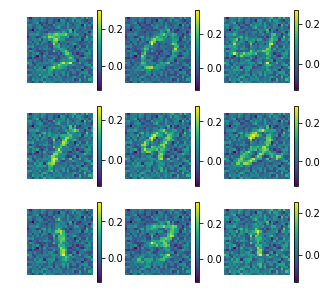

2.3035917
0.48014438
0.49987286
0.3501899
0.06324997
0.038049065
0.066430256
0.049838375
0.07272438
0.032807764
0.12569997
0.004051035
0.0687399
0.0041306345
0.004474168
0.02278561
0.0581284
0.014925386
0.042262513
0.003409021


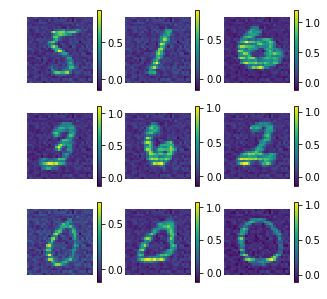

Accuracy is: 0.979375
optimized illumination phase [0.+0.32761645j]
optimized aperture phase [1.+0.7547253j]


0.979375

In [99]:
# double the aperture diameter
illumination_allow=True
aperture_allow=True
phase_constant=True
learning_rate=0.2
NA=8/28*2
illumination_aperture_train2(illumination_allow, aperture_allow, phase_constant, learning_rate,NA)